In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## 0 - Load data

In [2]:
import pandas as pd

#Load the data
path = "df_mini.csv"

final_df = pd.read_csv(path)

#Replace null values in text fields for an empty string
final_df['features'] = final_df['features'].fillna('')
final_df['description'] = final_df['description'].fillna('')
final_df['title'] = final_df['title'].fillna('')

print(f'data shape - {final_df.shape}')

final_df.head(3)

data shape - (18726, 12)


,title,len_title,description,len_description,features,len_features,num_features,main_cat,price,also_buy_categ,also_view_categ,num_images_categ
0,FRAM G6535 InLine Fuel Filter,29,Clean fuel is important because there are smal...,389,FRAM is the consumer's 1 choice Changing Fuel ...,343,5,Automotive,4.78,0,0,0
1,Kryptonite Transit HBar Carrier,31,The quick and convenient Transit HBar Carrier ...,291,Fits the majority of ulocks on the market Comp...,498,10,Sports & Outdoors,11.66,Other,Other,5
2,Double Accent 2MM Comfort Fit Stainless Steel ...,89,This beautiful 2MM Comfort Fit Stainless Steel...,245,316L Stainless Steel Shipping Information: Vie...,939,8,Amazon Fashion,12.99,1,Other,2


## 0.1 -TARGET DISTRIBUTION

In [27]:
final_df.main_cat.value_counts(normalize=True)

,proportion
main_cat,
Tools & Home Improvement,0.059543
Automotive,0.058849
"Arts, Crafts & Sewing",0.058101
Toys & Games,0.057727
Office Products,0.057407
Amazon Home,0.057140
Grocery,0.056232
Sports & Outdoors,0.056232
Books,0.055805


## 1 - Preprocess non-text features

### 1.1 - Log Transform numeric

We are going to check, for the numeric variables, if any of them shoulb be log transformed to correct skewness.

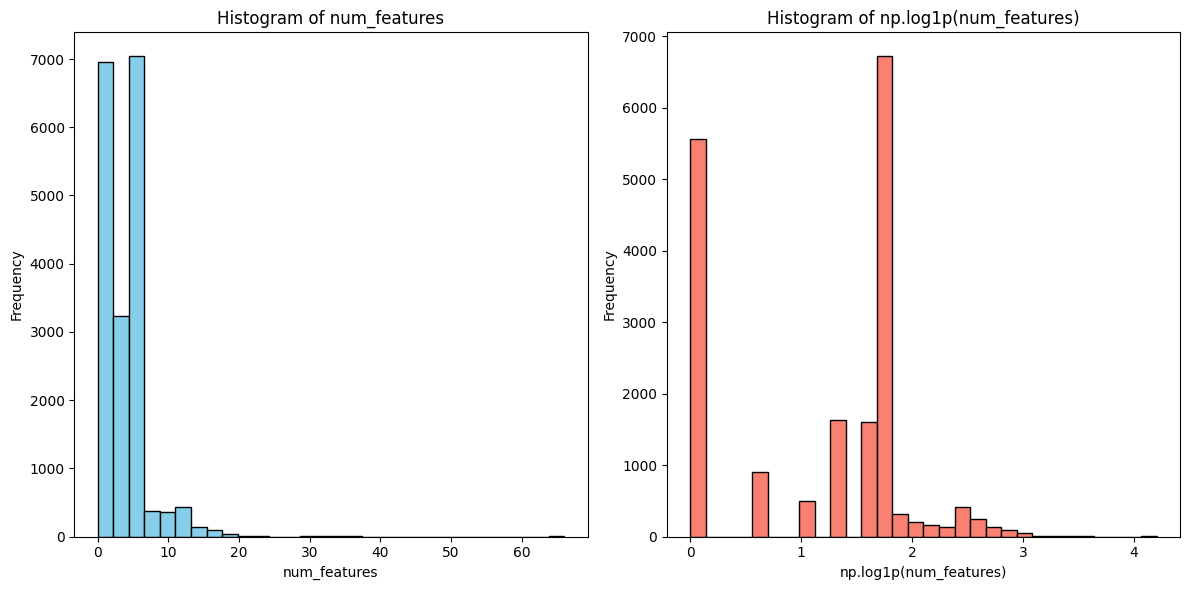

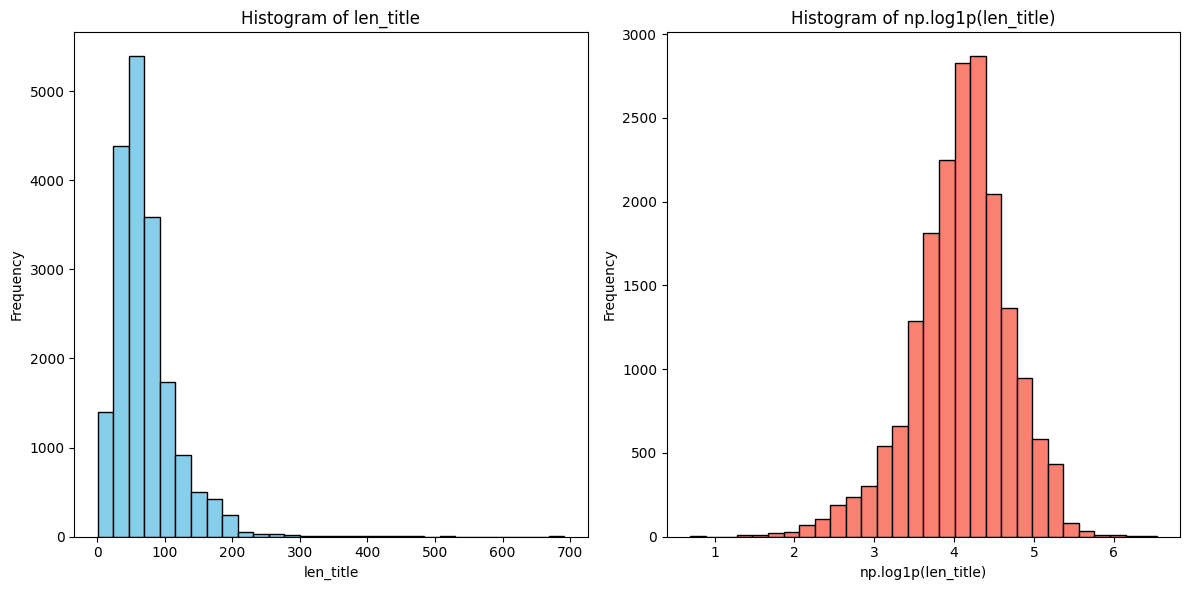

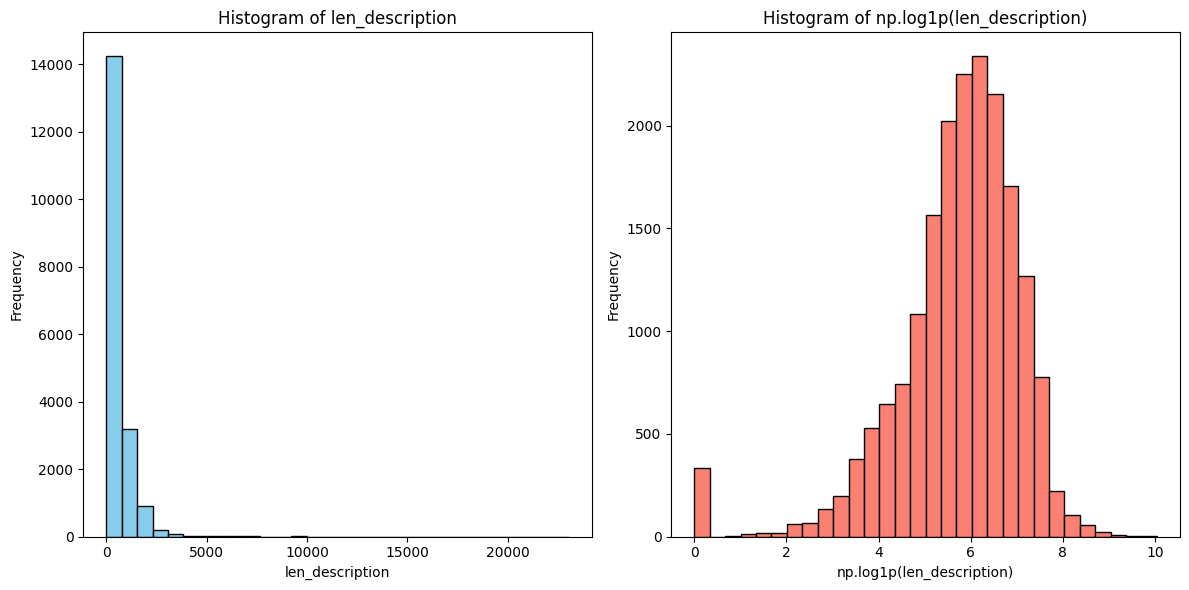

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Loop through variables and create the plots
variables = ['num_features', 'len_title', 'len_description']
for var in variables:
    # Create a figure with two subplots
    plt.figure(figsize=(12, 6))

    # Original histogram
    plt.subplot(1, 2, 1)
    plt.hist(final_df[var], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    # Log-transformed histogram
    plt.subplot(1, 2, 2)
    plt.hist(np.log1p(final_df[var]), bins=30, color='salmon', edgecolor='black')
    plt.title(f'Histogram of np.log1p({var})')
    plt.xlabel(f'np.log1p({var})')
    plt.ylabel('Frequency')

    # Display the plots
    plt.tight_layout()
    plt.show()

By looking at the graphs, we determine to log transform the three of them.

### 1.2 - Process features

- Encode target
- Log transform and standarize numeric
- One-Hot encode categorical

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

categ = ['also_buy_categ', 'also_view_categ', 'num_images_categ']
numeric = ['num_features', 'len_title', 'len_description']
log_numeric = ['num_features', 'len_title', 'len_description']

target = 'main_cat'

X = final_df[categ + numeric]
y = final_df[target]


# X_train.shape, X_test.shape, y_train.shape, y_test.shape
# Initialize and fit LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Map classes to integers
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Reverse mapping if needed later
inverse_class_mapping = {v: k for k, v in class_mapping.items()}

seed = 12345
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=seed, stratify=y  # Increased test size to 30%
)

In [7]:
def preprocess_data_consistent(train_df, test_df, categorical_vars, numeric_vars, log_numeric = []):
    """
    Preprocess train and test datasets consistently by fitting encoders on the train data
    and applying the same transformations to the test data.

    Parameters:
        train_df (pd.DataFrame): Training DataFrame.
        test_df (pd.DataFrame): Testing DataFrame.
        categorical_vars (list): List of categorical variable names.
        numeric_vars (list): List of numeric variable names.

    Returns:
        pd.DataFrame, pd.DataFrame: Transformed train and test DataFrames.
    """
    #Check log numeric is included in numeric vars
    # One-Hot Encode Categorical Variables
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    ohe.fit(train_df[categorical_vars])

    train_categorical = ohe.transform(train_df[categorical_vars])
    test_categorical = ohe.transform(test_df[categorical_vars])

    train_categorical_df = pd.DataFrame(
        train_categorical,
        columns=ohe.get_feature_names_out(categorical_vars),
        index=train_df.index
    )
    test_categorical_df = pd.DataFrame(
        test_categorical,
        columns=ohe.get_feature_names_out(categorical_vars),
        index=test_df.index
    )

    # Apply log1p to numeric values that requires it
    for col in log_numeric:
        X_train[col] = np.log1p(X_train[col])
        X_test[col] = np.log1p(X_test[col])

    # Standard Scale Numeric Variables
    scaler = StandardScaler()
    scaler.fit(train_df[numeric_vars])

    train_numeric = scaler.transform(train_df[numeric_vars])
    test_numeric = scaler.transform(test_df[numeric_vars])

    train_numeric_df = pd.DataFrame(
        train_numeric,
        columns=numeric_vars,
        index=train_df.index
    )
    test_numeric_df = pd.DataFrame(
        test_numeric,
        columns=numeric_vars,
        index=test_df.index
    )

    # Combine Encoded Categorical and Scaled Numeric Variables
    train_transformed = pd.concat([train_categorical_df, train_numeric_df], axis=1)
    test_transformed = pd.concat([test_categorical_df, test_numeric_df], axis=1)

    return train_transformed, test_transformed

In [8]:
# Preprocess the data
X_train_preprocessed, X_test_preprocessed = preprocess_data_consistent(
    X_train, X_test, categ, numeric, log_numeric
)

## 2 - Train Logistic Reg

First, train a very simple Logistic Regression only using the created features

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

def train_logistic_regression(X_train, X_test, y_train, y_test):
    """
    Train a logistic regression model on the preprocessed data and evaluate it.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target.
        y_test (pd.Series): Testing target.

    Returns:
        LogisticRegression: Trained logistic regression model.
    """
    # Initialize the logistic regression model
    model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    return model

In [10]:
logistic_model = train_logistic_regression(X_train_preprocessed, X_test_preprocessed, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.26183695265218937

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       238
           1       0.69      0.93      0.79       269
           2       0.10      0.12      0.11       321
           3       0.19      0.10      0.13       326
           4       0.13      0.26      0.18       331
           5       0.35      0.55      0.43       313
           6       0.17      0.01      0.01       165
           7       0.22      0.41      0.29       268
           8       0.15      0.24      0.18       302
           9       0.50      0.48      0.49       217
          10       0.42      0.66      0.52       316
          11       0.33      0.02      0.03        64
          12       0.00      0.00      0.00       150
          13       0.38      0.27      0.32       250
          14       0.34      0.38      0.36       273
          15       0.00      0.00      0.00       161
          16       0.13   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3 - Create text embeddings

To create more meaningfull variables, we will use text data to create features to be used in the model.

For that, we will use a Deep Learning pretrained model to generate embeddings out of the text features.

I have chosen a distil-bert model to generate them, as it is lighter and faster than a normal BERT, while still generating meaningful embeddings.

In [11]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

For each record, generate an embedding vector for each of the text columns:

- title
- description
- features

In [12]:
import numpy as np
from tqdm import tqdm
from datasets import Dataset


def get_bert_embeddings_hf(df, text_column, tokenizer, model, batch_size=32, max_length=128, device='cpu'):
    """
    Generate BERT embeddings for a text column using Hugging Face datasets and parallel processing.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        text_column (str): Name of the text column to process.
        tokenizer (Tokenizer): Pretrained tokenizer.
        model (Model): Pretrained BERT or DistilBERT model.
        batch_size (int): Batch size for tokenization and embedding generation.
        max_length (int): Maximum token length.
        device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
        list: List of embeddings for the text column.
    """
    # Convert DataFrame to Hugging Face Dataset
    dataset = Dataset.from_pandas(df[[text_column]])

    # Tokenize the text in batches
    def tokenize_batch(batch):
        return tokenizer(
            batch[text_column],
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

    dataset = dataset.map(tokenize_batch, batched=True, batch_size=batch_size)

    # Move model to the appropriate device
    model.to(device)

    # Generate embeddings in batches
    embeddings = []
    input_id_list = []
    attention_mask_list = []
    for i in tqdm(range(0, len(dataset), batch_size), desc=f"Processing {text_column}"):
        batch = dataset[i:i + batch_size]
        input_ids = torch.tensor(batch['input_ids']).to(device)
        attention_mask = torch.tensor(batch['attention_mask']).to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token

        embeddings.extend(cls_embeddings)

    return embeddings

In [13]:
# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Max length for texts
max_length = 256

# Generate embeddings for each text column
# Process each text column
for column in ['title', 'description', 'features']:
    final_df[f'{column}_emb'] = get_bert_embeddings_hf(
        final_df,
        text_column=column,
        tokenizer=tokenizer,
        model=distilbert,
        batch_size=256,
        max_length=max_length,
        device=device
    )

Map:   0%|          | 0/18726 [00:00<?, ? examples/s]

Processing title: 100%|██████████| 74/74 [00:49<00:00,  1.48it/s]


Map:   0%|          | 0/18726 [00:00<?, ? examples/s]

Processing description: 100%|██████████| 74/74 [02:15<00:00,  1.83s/it]


Map:   0%|          | 0/18726 [00:00<?, ? examples/s]

Processing features: 100%|██████████| 74/74 [02:15<00:00,  1.83s/it]


In [14]:
# Display the updated DataFrame
final_df[[f'{column}_emb' for column in ['title', 'description', 'features']]].head()

,title_emb,description_emb,features_emb
0,"[-0.33970937, -0.14052069, 0.058355477, -0.125...","[-0.2173604, -0.040767107, 0.03600766, 0.13853...","[-0.18456016, -0.1472086, 0.4525508, 0.0443072..."
1,"[-0.36181694, -0.09453951, -0.40946513, -0.101...","[-0.31227216, -0.23831831, 0.19799465, 0.21152...","[-0.4002151, -0.10326757, 0.161922, -0.0062077..."
2,"[-0.19045362, -0.35250556, 0.2207744, -0.14431...","[-0.25852072, -0.27653632, 0.18439013, -0.0004...","[-0.36996695, -0.15155633, 0.079592094, 0.0362..."
3,"[-0.3877841, -0.12987053, 0.10380132, -0.09797...","[-0.4799227, -0.3261352, 0.3394701, -0.0467377...","[-0.54794323, -0.32096547, 0.2709508, -0.02574..."
4,"[-0.20085979, -0.1443409, 0.08972699, -0.10345...","[-0.2877157, -0.22141042, 0.25516853, 0.018671...","[-0.1890923, -0.059448488, 0.036933996, -0.163..."


## 4 - Train features + embeddings model

Now, using the generated embeddings, we will use them along with the previous features as input for the model.

In [15]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

categ = ['also_buy_categ', 'also_view_categ', 'num_images_categ']
numeric = ['num_features', 'len_title', 'len_description']
log_numeric = ['num_features', 'len_title', 'len_description']
embed = ['description_emb', 'title_emb', 'features_emb']

target = 'main_cat'

X = final_df[categ + numeric + embed]
y = final_df[target]


# X_train.shape, X_test.shape, y_train.shape, y_test.shape
# Initialize and fit LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Map classes to integers
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Reverse mapping if needed later
inverse_class_mapping = {v: k for k, v in class_mapping.items()}

seed = 12345
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=seed, stratify=y  # Increased test size to 30%
)

Now, the data preprocessing part of the numeric and categorical featues is exactly the same.

The embeddings features could be implemented in two ways:
- Concatenating the three embeddings: This would ensure each text column gets its full and isolated representation as feature. But it will imply adding 768 (Bert embed dimension) * 3 (number of text columns) new features

- Adding the embeddings: As the 3 embedding vectors have the same dimension, they could be added, to form an unique 792 length vector, containing the combined information of the embeddings of the three columns.

We saw that, for some records, either description, title or features could be an empty string, but never the three of them. This mean that, by adding them, we are not only reducing the number of features and speeding up training, but also ensuring that each vector has meaningful information about the row.

For that reason, we will add the embeddings up instead of concatenate them.

In [16]:
# Preprocess the data
X_train_preprocessed, X_test_preprocessed = preprocess_data_consistent(
    X_train[categ + numeric], X_test[categ + numeric], categ, numeric, log_numeric
)

# Define embedding columns
embedding_columns = ['description_emb', 'title_emb', 'features_emb']

# Sum all embeddings for train and test sets
X_train_embeddings = np.sum([np.vstack(X_train[col].values) for col in embedding_columns], axis=0)
X_test_embeddings = np.sum([np.vstack(X_test[col].values) for col in embedding_columns], axis=0)

# Combine preprocessed structured features with summed embeddings
X_train_final = np.hstack([X_train_preprocessed.values, X_train_embeddings])
X_test_final = np.hstack([X_test_preprocessed.values, X_test_embeddings])

Now, with all the features prepared, train the model.

In [18]:
# Train the logistic regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
logistic_model.fit(X_train_final, y_train)

# Predict and evaluate
y_pred = logistic_model.predict(X_test_final)
y_probs = logistic_model.predict_proba(X_test_final)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.7443930224279103

Classification Report:
                            precision    recall  f1-score   support

          All Electronics       0.39      0.27      0.32       238
           Amazon Fashion       0.93      0.96      0.94       269
              Amazon Home       0.60      0.55      0.57       321
    Arts, Crafts & Sewing       0.70      0.71      0.71       326
               Automotive       0.76      0.85      0.81       331
                    Books       0.91      0.95      0.93       313
           Camera & Photo       0.72      0.69      0.71       165
Cell Phones & Accessories       0.72      0.80      0.76       268
                Computers       0.66      0.69      0.67       302
            Digital Music       0.87      0.89      0.88       217
                  Grocery       0.96      0.98      0.97       316
   Health & Personal Care       0.52      0.47      0.49        64
     Home Audio & Theater       0.51      0.45      0.48       150
  Indus

## 5 - XGBoost

Having already the data prepared, we will try more models. Next is XGBoost

In [19]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Convert data into DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_final, label=y_train)
dtest = xgb.DMatrix(X_test_final, label=y_test)

# Define XGBoost parameters
params = {
    "objective": "multi:softmax",  # For multi-class classification
    "num_class": len(set(y_train)),  # Number of unique classes
    "max_depth": 6,                 # Maximum tree depth
    "eta": 0.3,                     # Learning rate
    "eval_metric": "merror",        # Evaluation metric for multi-class
    "seed": 42                      # Random seed for reproducibility
}

# Train the model
num_round = 100  # Number of boosting rounds

In [20]:
bst = xgb.train(
    params,
    dtrain,
    num_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	Test-merror:0.45603
[1]	Test-merror:0.42221
[2]	Test-merror:0.40263
[3]	Test-merror:0.39106
[4]	Test-merror:0.37789
[5]	Test-merror:0.37255
[6]	Test-merror:0.36276
[7]	Test-merror:0.35760
[8]	Test-merror:0.35190
[9]	Test-merror:0.34906
[10]	Test-merror:0.34478
[11]	Test-merror:0.33944
[12]	Test-merror:0.33588
[13]	Test-merror:0.33606
[14]	Test-merror:0.32859
[15]	Test-merror:0.32770
[16]	Test-merror:0.32467
[17]	Test-merror:0.32378
[18]	Test-merror:0.32147
[19]	Test-merror:0.31986
[20]	Test-merror:0.31595
[21]	Test-merror:0.31328
[22]	Test-merror:0.30954
[23]	Test-merror:0.30972
[24]	Test-merror:0.30883
[25]	Test-merror:0.30865
[26]	Test-merror:0.30847
[27]	Test-merror:0.30740
[28]	Test-merror:0.30598
[29]	Test-merror:0.30402
[30]	Test-merror:0.30509
[31]	Test-merror:0.30367
[32]	Test-merror:0.30331
[33]	Test-merror:0.30064
[34]	Test-merror:0.30117
[35]	Test-merror:0.30100
[36]	Test-merror:0.29993
[37]	Test-merror:0.29975
[38]	Test-merror:0.29957
[39]	Test-merror:0.29868
[40]	Test-

Test it

In [21]:
# Predict on the test set
y_pred = bst.predict(dtest)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.7249911000355999

Classification Report:
                            precision    recall  f1-score   support

          All Electronics       0.35      0.31      0.33       238
           Amazon Fashion       0.94      0.97      0.96       269
              Amazon Home       0.57      0.56      0.56       321
    Arts, Crafts & Sewing       0.66      0.70      0.68       326
               Automotive       0.75      0.81      0.78       331
                    Books       0.90      0.91      0.91       313
           Camera & Photo       0.75      0.67      0.71       165
Cell Phones & Accessories       0.70      0.79      0.74       268
                Computers       0.64      0.63      0.64       302
            Digital Music       0.83      0.86      0.85       217
                  Grocery       0.94      0.98      0.96       316
   Health & Personal Care       0.50      0.31      0.38        64
     Home Audio & Theater       0.46      0.38      0.41       150
  Indus

## 6 - Neural Network

Neural network

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batching
batch_size = 1024
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Fully connected layer 1
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)         # Fully connected layer 2
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes) # Output layer
        self.dropout = nn.Dropout(0.3)        # Dropout for regularization

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout(x)
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
# Initialize the model
input_size = X_train_final.shape[1]
num_classes = len(set(y_train))
model = SimpleNN(input_size, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleNN(
  (fc1): Linear(in_features=792, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=22, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [25]:
# Training loop with test loss and tqdm
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Evaluate on test data
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 24.08it/s]


Epoch 1/150, Train Loss: 2.8674, Test Loss: 2.4775


Epoch 2/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 95.61it/s]


Epoch 2/150, Train Loss: 2.2932, Test Loss: 1.9204


Epoch 3/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 99.78it/s]


Epoch 3/150, Train Loss: 1.8804, Test Loss: 1.5919


Epoch 4/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 27.73it/s]


Epoch 4/150, Train Loss: 1.6184, Test Loss: 1.3942


Epoch 5/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.54it/s]


Epoch 5/150, Train Loss: 1.4390, Test Loss: 1.2497


Epoch 6/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.96it/s]


Epoch 6/150, Train Loss: 1.3227, Test Loss: 1.1507


Epoch 7/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.72it/s]


Epoch 7/150, Train Loss: 1.2378, Test Loss: 1.0933


Epoch 8/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.84it/s]


Epoch 8/150, Train Loss: 1.1777, Test Loss: 1.0539


Epoch 9/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.04it/s]


Epoch 9/150, Train Loss: 1.1389, Test Loss: 1.0159


Epoch 10/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.29it/s]


Epoch 10/150, Train Loss: 1.1005, Test Loss: 0.9884


Epoch 11/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 96.87it/s]


Epoch 11/150, Train Loss: 1.0661, Test Loss: 0.9668


Epoch 12/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 101.44it/s]


Epoch 12/150, Train Loss: 1.0431, Test Loss: 0.9472


Epoch 13/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.82it/s]


Epoch 13/150, Train Loss: 1.0221, Test Loss: 0.9349


Epoch 14/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.81it/s]


Epoch 14/150, Train Loss: 1.0031, Test Loss: 0.9191


Epoch 15/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.46it/s]


Epoch 15/150, Train Loss: 0.9784, Test Loss: 0.9062


Epoch 16/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.64it/s]


Epoch 16/150, Train Loss: 0.9713, Test Loss: 0.8995


Epoch 17/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 27.68it/s] 


Epoch 17/150, Train Loss: 0.9565, Test Loss: 0.8906


Epoch 18/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.80it/s]


Epoch 18/150, Train Loss: 0.9431, Test Loss: 0.8790


Epoch 19/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.47it/s]


Epoch 19/150, Train Loss: 0.9276, Test Loss: 0.8869


Epoch 20/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.88it/s]


Epoch 20/150, Train Loss: 0.9217, Test Loss: 0.8674


Epoch 21/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.73it/s]


Epoch 21/150, Train Loss: 0.9093, Test Loss: 0.8621


Epoch 22/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 100.86it/s]


Epoch 22/150, Train Loss: 0.8940, Test Loss: 0.8568


Epoch 23/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.06it/s]


Epoch 23/150, Train Loss: 0.8908, Test Loss: 0.8559


Epoch 24/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 108.38it/s]


Epoch 24/150, Train Loss: 0.8823, Test Loss: 0.8547


Epoch 25/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.60it/s]


Epoch 25/150, Train Loss: 0.8766, Test Loss: 0.8406


Epoch 26/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.44it/s]


Epoch 26/150, Train Loss: 0.8610, Test Loss: 0.8364


Epoch 27/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.22it/s]


Epoch 27/150, Train Loss: 0.8508, Test Loss: 0.8439


Epoch 28/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 99.72it/s] 


Epoch 28/150, Train Loss: 0.8441, Test Loss: 0.8315


Epoch 29/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.43it/s]


Epoch 29/150, Train Loss: 0.8375, Test Loss: 0.8295


Epoch 30/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.83it/s]


Epoch 30/150, Train Loss: 0.8322, Test Loss: 0.8272


Epoch 31/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 28.86it/s]


Epoch 31/150, Train Loss: 0.8339, Test Loss: 0.8253


Epoch 32/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 100.19it/s]


Epoch 32/150, Train Loss: 0.8196, Test Loss: 0.8252


Epoch 33/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.19it/s]


Epoch 33/150, Train Loss: 0.8128, Test Loss: 0.8296


Epoch 34/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.65it/s]


Epoch 34/150, Train Loss: 0.8147, Test Loss: 0.8232


Epoch 35/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.82it/s]


Epoch 35/150, Train Loss: 0.8049, Test Loss: 0.8178


Epoch 36/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.95it/s]


Epoch 36/150, Train Loss: 0.7970, Test Loss: 0.8260


Epoch 37/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.27it/s]


Epoch 37/150, Train Loss: 0.8001, Test Loss: 0.8230


Epoch 38/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 97.97it/s]


Epoch 38/150, Train Loss: 0.7850, Test Loss: 0.8194


Epoch 39/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.92it/s]


Epoch 39/150, Train Loss: 0.7838, Test Loss: 0.8097


Epoch 40/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 100.41it/s]


Epoch 40/150, Train Loss: 0.7728, Test Loss: 0.8134


Epoch 41/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.69it/s]


Epoch 41/150, Train Loss: 0.7732, Test Loss: 0.8078


Epoch 42/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.35it/s]


Epoch 42/150, Train Loss: 0.7635, Test Loss: 0.8067


Epoch 43/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.25it/s]


Epoch 43/150, Train Loss: 0.7618, Test Loss: 0.7999


Epoch 44/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 28.69it/s] 


Epoch 44/150, Train Loss: 0.7507, Test Loss: 0.8023


Epoch 45/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.02it/s]


Epoch 45/150, Train Loss: 0.7448, Test Loss: 0.8078


Epoch 46/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.32it/s]


Epoch 46/150, Train Loss: 0.7554, Test Loss: 0.8009


Epoch 47/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.30it/s]


Epoch 47/150, Train Loss: 0.7460, Test Loss: 0.8021


Epoch 48/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.19it/s]


Epoch 48/150, Train Loss: 0.7429, Test Loss: 0.7998


Epoch 49/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 108.79it/s]


Epoch 49/150, Train Loss: 0.7339, Test Loss: 0.8038


Epoch 50/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 109.00it/s]


Epoch 50/150, Train Loss: 0.7310, Test Loss: 0.7985


Epoch 51/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.96it/s]


Epoch 51/150, Train Loss: 0.7228, Test Loss: 0.7987


Epoch 52/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.28it/s]


Epoch 52/150, Train Loss: 0.7202, Test Loss: 0.7991


Epoch 53/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.91it/s]


Epoch 53/150, Train Loss: 0.7167, Test Loss: 0.8012


Epoch 54/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.60it/s]


Epoch 54/150, Train Loss: 0.7172, Test Loss: 0.8034


Epoch 55/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.32it/s]


Epoch 55/150, Train Loss: 0.7101, Test Loss: 0.7941


Epoch 56/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.85it/s]


Epoch 56/150, Train Loss: 0.7014, Test Loss: 0.7933


Epoch 57/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.54it/s]


Epoch 57/150, Train Loss: 0.6994, Test Loss: 0.7981


Epoch 58/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 28.87it/s]


Epoch 58/150, Train Loss: 0.6970, Test Loss: 0.7997


Epoch 59/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.91it/s]


Epoch 59/150, Train Loss: 0.6959, Test Loss: 0.7982


Epoch 60/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.79it/s]


Epoch 60/150, Train Loss: 0.6917, Test Loss: 0.7901


Epoch 61/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.04it/s]


Epoch 61/150, Train Loss: 0.6760, Test Loss: 0.7963


Epoch 62/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 94.05it/s]


Epoch 62/150, Train Loss: 0.6778, Test Loss: 0.7945


Epoch 63/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 95.87it/s]


Epoch 63/150, Train Loss: 0.6815, Test Loss: 0.8051


Epoch 64/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.61it/s]


Epoch 64/150, Train Loss: 0.6728, Test Loss: 0.7987


Epoch 65/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.96it/s]


Epoch 65/150, Train Loss: 0.6620, Test Loss: 0.7851


Epoch 66/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 108.51it/s]


Epoch 66/150, Train Loss: 0.6561, Test Loss: 0.7916


Epoch 67/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.83it/s]


Epoch 67/150, Train Loss: 0.6641, Test Loss: 0.7984


Epoch 68/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.53it/s]


Epoch 68/150, Train Loss: 0.6577, Test Loss: 0.7940


Epoch 69/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.99it/s]


Epoch 69/150, Train Loss: 0.6508, Test Loss: 0.7931


Epoch 70/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.28it/s]


Epoch 70/150, Train Loss: 0.6556, Test Loss: 0.7928


Epoch 71/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 98.55it/s]


Epoch 71/150, Train Loss: 0.6392, Test Loss: 0.7899


Epoch 72/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.79it/s]


Epoch 72/150, Train Loss: 0.6421, Test Loss: 0.7931


Epoch 73/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.04it/s]


Epoch 73/150, Train Loss: 0.6361, Test Loss: 0.8005


Epoch 74/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.15it/s]


Epoch 74/150, Train Loss: 0.6378, Test Loss: 0.7993


Epoch 75/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.83it/s]


Epoch 75/150, Train Loss: 0.6333, Test Loss: 0.7936


Epoch 76/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 99.77it/s]


Epoch 76/150, Train Loss: 0.6238, Test Loss: 0.7941


Epoch 77/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 97.98it/s]


Epoch 77/150, Train Loss: 0.6222, Test Loss: 0.8013


Epoch 78/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 97.94it/s]


Epoch 78/150, Train Loss: 0.6228, Test Loss: 0.7905


Epoch 79/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.03it/s]


Epoch 79/150, Train Loss: 0.6137, Test Loss: 0.8010


Epoch 80/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 101.98it/s]


Epoch 80/150, Train Loss: 0.6135, Test Loss: 0.7969


Epoch 81/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.50it/s]


Epoch 81/150, Train Loss: 0.6116, Test Loss: 0.8065


Epoch 82/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.22it/s]


Epoch 82/150, Train Loss: 0.6124, Test Loss: 0.7951


Epoch 83/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 101.22it/s]


Epoch 83/150, Train Loss: 0.6038, Test Loss: 0.7972


Epoch 84/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.84it/s]


Epoch 84/150, Train Loss: 0.6048, Test Loss: 0.8030


Epoch 85/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 27.56it/s]


Epoch 85/150, Train Loss: 0.6040, Test Loss: 0.7974


Epoch 86/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.96it/s]


Epoch 86/150, Train Loss: 0.5997, Test Loss: 0.7958


Epoch 87/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.59it/s]


Epoch 87/150, Train Loss: 0.5943, Test Loss: 0.7990


Epoch 88/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.43it/s]


Epoch 88/150, Train Loss: 0.5930, Test Loss: 0.8041


Epoch 89/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 96.06it/s]


Epoch 89/150, Train Loss: 0.5874, Test Loss: 0.7917


Epoch 90/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.48it/s]


Epoch 90/150, Train Loss: 0.5817, Test Loss: 0.8073


Epoch 91/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.40it/s]


Epoch 91/150, Train Loss: 0.5804, Test Loss: 0.8114


Epoch 92/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.55it/s]


Epoch 92/150, Train Loss: 0.5653, Test Loss: 0.8047


Epoch 93/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.30it/s]


Epoch 93/150, Train Loss: 0.5738, Test Loss: 0.8075


Epoch 94/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.25it/s]


Epoch 94/150, Train Loss: 0.5705, Test Loss: 0.8067


Epoch 95/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.42it/s]


Epoch 95/150, Train Loss: 0.5590, Test Loss: 0.8122


Epoch 96/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.07it/s]


Epoch 96/150, Train Loss: 0.5625, Test Loss: 0.8098


Epoch 97/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.90it/s]


Epoch 97/150, Train Loss: 0.5539, Test Loss: 0.8038


Epoch 98/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 28.81it/s] 


Epoch 98/150, Train Loss: 0.5536, Test Loss: 0.8039


Epoch 99/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.09it/s]


Epoch 99/150, Train Loss: 0.5506, Test Loss: 0.8101


Epoch 100/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.90it/s]


Epoch 100/150, Train Loss: 0.5461, Test Loss: 0.8160


Epoch 101/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.78it/s]


Epoch 101/150, Train Loss: 0.5465, Test Loss: 0.8055


Epoch 102/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 108.71it/s]


Epoch 102/150, Train Loss: 0.5403, Test Loss: 0.8038


Epoch 103/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.74it/s]


Epoch 103/150, Train Loss: 0.5416, Test Loss: 0.8182


Epoch 104/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.52it/s]


Epoch 104/150, Train Loss: 0.5505, Test Loss: 0.8156


Epoch 105/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.24it/s]


Epoch 105/150, Train Loss: 0.5372, Test Loss: 0.8071


Epoch 106/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 108.24it/s]


Epoch 106/150, Train Loss: 0.5406, Test Loss: 0.8184


Epoch 107/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.87it/s]


Epoch 107/150, Train Loss: 0.5312, Test Loss: 0.8184


Epoch 108/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 108.17it/s]


Epoch 108/150, Train Loss: 0.5294, Test Loss: 0.8094


Epoch 109/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 100.11it/s]


Epoch 109/150, Train Loss: 0.5215, Test Loss: 0.8178


Epoch 110/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.66it/s]


Epoch 110/150, Train Loss: 0.5153, Test Loss: 0.8135


Epoch 111/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.60it/s]


Epoch 111/150, Train Loss: 0.5257, Test Loss: 0.8182


Epoch 112/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 29.09it/s]


Epoch 112/150, Train Loss: 0.5077, Test Loss: 0.8281


Epoch 113/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.80it/s]


Epoch 113/150, Train Loss: 0.5151, Test Loss: 0.8302


Epoch 114/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.90it/s]


Epoch 114/150, Train Loss: 0.5044, Test Loss: 0.8219


Epoch 115/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.86it/s]


Epoch 115/150, Train Loss: 0.5101, Test Loss: 0.8171


Epoch 116/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.50it/s]


Epoch 116/150, Train Loss: 0.5037, Test Loss: 0.8365


Epoch 117/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.48it/s]


Epoch 117/150, Train Loss: 0.5003, Test Loss: 0.8202


Epoch 118/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.71it/s]


Epoch 118/150, Train Loss: 0.4955, Test Loss: 0.8224


Epoch 119/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 101.11it/s]


Epoch 119/150, Train Loss: 0.5022, Test Loss: 0.8290


Epoch 120/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.92it/s]


Epoch 120/150, Train Loss: 0.4953, Test Loss: 0.8226


Epoch 121/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.04it/s]


Epoch 121/150, Train Loss: 0.4874, Test Loss: 0.8243


Epoch 122/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.90it/s]


Epoch 122/150, Train Loss: 0.4828, Test Loss: 0.8318


Epoch 123/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.70it/s]


Epoch 123/150, Train Loss: 0.4934, Test Loss: 0.8377


Epoch 124/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.25it/s]


Epoch 124/150, Train Loss: 0.4903, Test Loss: 0.8390


Epoch 125/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 29.23it/s]


Epoch 125/150, Train Loss: 0.4885, Test Loss: 0.8348


Epoch 126/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.80it/s]


Epoch 126/150, Train Loss: 0.4756, Test Loss: 0.8370


Epoch 127/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 108.36it/s]


Epoch 127/150, Train Loss: 0.4738, Test Loss: 0.8415


Epoch 128/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.55it/s]


Epoch 128/150, Train Loss: 0.4640, Test Loss: 0.8373


Epoch 129/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 95.85it/s]


Epoch 129/150, Train Loss: 0.4640, Test Loss: 0.8492


Epoch 130/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.90it/s]


Epoch 130/150, Train Loss: 0.4639, Test Loss: 0.8297


Epoch 131/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.42it/s]


Epoch 131/150, Train Loss: 0.4638, Test Loss: 0.8403


Epoch 132/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.62it/s]


Epoch 132/150, Train Loss: 0.4630, Test Loss: 0.8503


Epoch 133/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 109.48it/s]


Epoch 133/150, Train Loss: 0.4607, Test Loss: 0.8501


Epoch 134/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 100.74it/s]


Epoch 134/150, Train Loss: 0.4511, Test Loss: 0.8367


Epoch 135/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 99.51it/s]


Epoch 135/150, Train Loss: 0.4495, Test Loss: 0.8309


Epoch 136/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.22it/s]


Epoch 136/150, Train Loss: 0.4534, Test Loss: 0.8471


Epoch 137/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.20it/s]


Epoch 137/150, Train Loss: 0.4447, Test Loss: 0.8482


Epoch 138/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 102.42it/s]


Epoch 138/150, Train Loss: 0.4480, Test Loss: 0.8492


Epoch 139/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 28.25it/s]


Epoch 139/150, Train Loss: 0.4493, Test Loss: 0.8528


Epoch 140/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.54it/s]


Epoch 140/150, Train Loss: 0.4351, Test Loss: 0.8553


Epoch 141/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 105.96it/s]


Epoch 141/150, Train Loss: 0.4452, Test Loss: 0.8664


Epoch 142/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.61it/s]


Epoch 142/150, Train Loss: 0.4432, Test Loss: 0.8564


Epoch 143/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 104.97it/s]


Epoch 143/150, Train Loss: 0.4300, Test Loss: 0.8549


Epoch 144/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 103.59it/s]


Epoch 144/150, Train Loss: 0.4307, Test Loss: 0.8530


Epoch 145/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.06it/s]


Epoch 145/150, Train Loss: 0.4285, Test Loss: 0.8654


Epoch 146/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.39it/s]


Epoch 146/150, Train Loss: 0.4308, Test Loss: 0.8654


Epoch 147/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 106.38it/s]


Epoch 147/150, Train Loss: 0.4285, Test Loss: 0.8656


Epoch 148/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 107.55it/s]


Epoch 148/150, Train Loss: 0.4313, Test Loss: 0.8736


Epoch 149/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 108.23it/s]


Epoch 149/150, Train Loss: 0.4237, Test Loss: 0.8767


Epoch 150/150 - Training: 100%|██████████| 13/13 [00:00<00:00, 89.62it/s]


Epoch 150/150, Train Loss: 0.4250, Test Loss: 0.8945


In [26]:
# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Compute metrics
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

Accuracy: 0.7490210039159844

Classification Report:
                            precision    recall  f1-score   support

          All Electronics       0.42      0.29      0.34       238
           Amazon Fashion       0.94      0.96      0.95       269
              Amazon Home       0.61      0.56      0.58       321
    Arts, Crafts & Sewing       0.70      0.73      0.71       326
               Automotive       0.79      0.82      0.80       331
                    Books       0.90      0.95      0.92       313
           Camera & Photo       0.73      0.72      0.73       165
Cell Phones & Accessories       0.74      0.81      0.78       268
                Computers       0.68      0.67      0.68       302
            Digital Music       0.87      0.89      0.88       217
                  Grocery       0.96      0.98      0.97       316
   Health & Personal Care       0.51      0.38      0.43        64
     Home Audio & Theater       0.45      0.59      0.51       150
  Indus

## 7 - Conclusion

Looking at the result of the models, we can see a similar performance of the three of them, Having a lot of target classes (22), still they reach around 74% accuracy.

I have decided to use a **Logistic Regression**, for the following reasons:
- Resources: A logistic regression takes very little resources to train and deploy, and do not need a GPU for faster training/inference, like a NN would.
- Simplicity: Is a very simple model, if needed, we could interpret the coefficients of each variable to understand how they relate to the target (this would be more difficult with the embeddings, but can be done with the rest of variables).
- Handle imbalances: As we saw, the dataset is imbalanced, which depending on the case can be a problem or not. If we decide to act on it, a logistic regression offers a simple way to manage it with the `class_weight` parameter.